
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [160]:
## library imports here
import pandas as pd
from sklearn import *
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, cohen_kappa_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from plotnine import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [161]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [162]:
X = ha.drop(["cp"], axis = 1)
y = ha["cp"]

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [163]:
#column transformer function
def model(regression_label, type_of_regression):

    """
    transforms columns and outputs a pipeline of the desired kind of regression model

    Parameter
    ---------
    regression_label : str
    A string represeting the label of the modeling type

    type_of_regression: sklearn function
    A specific function for the modeling type

    Returns
    -------
    arrays
    returns the pipeline of the specified type of model
    """

    ct = ColumnTransformer([
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown = "ignore"), ["sex", "output", "restecg"]),
    ("standardize", StandardScaler(), ["age", "trtbps", "chol", "thalach"])], remainder = "passthrough")

    pipeline = Pipeline(
      [("preprocessing", ct),
      (regression_label, type_of_regression)]
    ).set_output(transform = "pandas")

    return pipeline

In [164]:
#knn
pipeline_knn = model("knn", KNeighborsClassifier())

#tuning to see which k value is best
k_values = [1, 10, 30, 50, 80, 100]

param = {'knn__n_neighbors': k_values}

#running girdsearchcv to tune to different n_neighbor values
gscv_knn = GridSearchCV(pipeline_knn, param, cv = 5, scoring='accuracy')
gscv_fitted_knn = gscv_knn.fit(X, y)
#creating dataframe for n_neighbor values and roc_auc scores
n_neighbor_df = pd.DataFrame(gscv_fitted_knn.cv_results_)
n_neighbor_df

#sorted table of number of neighbors and the roc_auc score
n_neighbor_df = n_neighbor_df[["param_knn__n_neighbors", "mean_test_score"]]
print(n_neighbor_df.sort_values(by = "mean_test_score", ascending = False))

#fit and predict with tuned n_neighbors
pipeline_knn30 = model("knn", KNeighborsClassifier(n_neighbors = 30))
fitted_pipeline_knn30 = pipeline_knn30.fit(X,y)
y_preds_knn30 = fitted_pipeline_knn30.predict(X)
print(y_preds_knn30)

#confusion matrix
conf_matrix_knn = confusion_matrix(y, y_preds_knn30)
pd.DataFrame(conf_matrix_knn)

  param_knn__n_neighbors  mean_test_score
2                     30         0.538451
1                     10         0.523973
3                     50         0.520337
4                     80         0.520337
5                    100         0.509293
0                      1         0.421684
[2 2 1 1 2 2 1 2 2 2 2 1 2 2 1 0 2 0 2 0 2 2 0 0 2 2 0 2 0 2 2 2 2 0 0 2 0
 2 2 1 2 2 0 2 2 0 0 2 2 1 2 2 0 1 2 2 2 2 1 2 2 0 2 2 2 2 2 2 2 1 1 2 0 2
 0 0 2 0 2 2 2 2 0 0 2 1 2 0 2 1 2 0 2 0 2 2 2 1 2 2 2 2 2 0 2 2 2 2 2 2 0
 2 2 1 2 2 2 0 0 0 0 2 1 2 0 0 2 2 2 2 2 0 0 2 0 2 0 1 2 0 2 1 1 2 2 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


,0,1,2,3
0,110,3,15,0
1,11,10,23,0
2,31,6,44,0
3,11,0,9,0


In [165]:
#decision tree
pipeline_dt = model("dt", DecisionTreeClassifier())

#find best branch number by tuning
max_depth = [1, 5, 10, 30, 50]

param = {'dt__max_depth': max_depth}

#running girdsearchcv to tune to different n_neighbor values
gscv_dt = GridSearchCV(pipeline_dt, param, cv = 5, scoring='accuracy')
gscv_fitted_dt = gscv_dt.fit(X, y)
#creating dataframe for n_neighbor values and accuracy
max_depth_df = pd.DataFrame(gscv_fitted_dt.cv_results_)
max_depth_df
#sorted table of max_depth and the roc_auc score
max_depth_df = max_depth_df[["param_dt__max_depth", "mean_test_score"]]
print(max_depth_df.sort_values(by = "mean_test_score", ascending = False))

#fit model
pipeline_dt1 = model("dt", DecisionTreeClassifier(max_depth = 1))
fitted_pipeline_dt1 = pipeline_dt1.fit(X, y)
fitted_pipeline_dt1

#predict output
y_preds_dt1 = fitted_pipeline_dt1.predict(X)
print(y_preds_dt1)

#confusion matrix
conf_matrix_dt1 = confusion_matrix(y, y_preds_dt1)
pd.DataFrame(conf_matrix_dt1)

  param_dt__max_depth  mean_test_score
0                   1         0.575219
1                   5         0.417441
2                  10         0.381077
3                  30         0.373737
4                  50         0.370101
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


,0,1,2,3
0,94,0,34,0
1,8,0,36,0
2,18,0,63,0
3,7,0,13,0


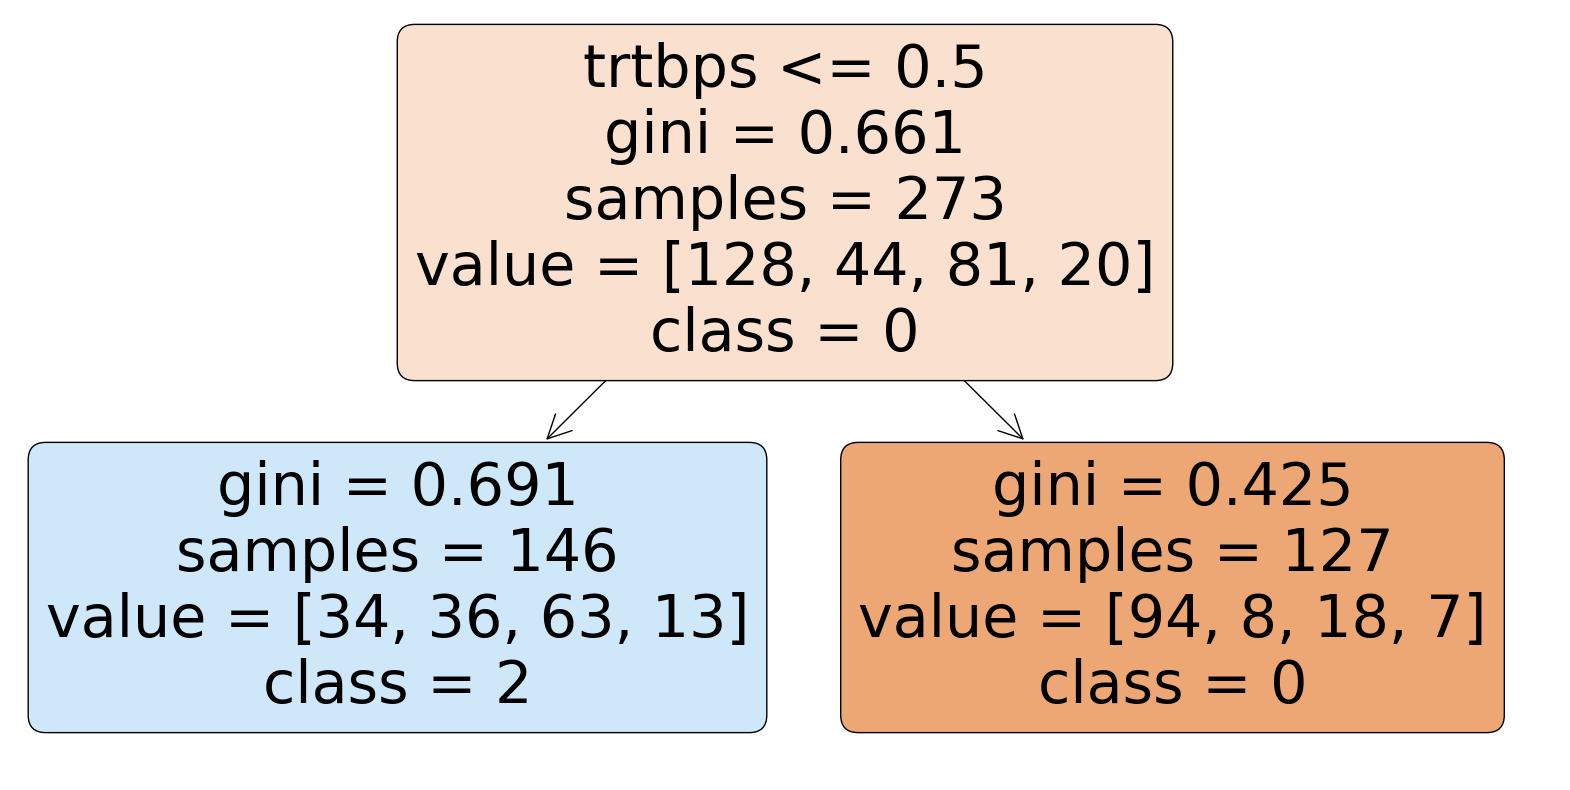

In [166]:
#decision tree plot
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

decision_tree_model = fitted_pipeline_dt1.named_steps['dt']

plt.figure(figsize=(20,10))
plot_tree(decision_tree_model, filled=True, rounded=True, class_names=['0', '1', "2", "3"], feature_names=X.columns)
plt.show()

The top of the decision tree represents the entire dataset. The two braches show that there is only one split (max_depth=1). The best decision tree model is when there is only one split. The model was more able to accurately categorize chest pain levels 0 and 2.

In [167]:
# LDA
pipeline_lda = model("lda", LinearDiscriminantAnalysis())

#fit model
pipeline_lda_fitted = pipeline_lda.fit(X, y)
pipeline_lda_fitted

#predict output
y_preds_lda = pipeline_lda_fitted.predict(X)
y_preds_lda

#confusion matrix
conf_matrix_lda = confusion_matrix(y, y_preds_lda)
pd.DataFrame(conf_matrix_lda)



,0,1,2,3
0,97,1,29,1
1,8,2,32,2
2,21,5,55,0
3,7,0,11,2


## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [168]:
ha["cp_is_3"] = (ha["cp"] == 3).astype(int)
ha.head()

X3 = ha.drop(["cp_is_3"], axis = 1)
y3 = ha["cp_is_3"]

In [170]:
#logistic regression
pipeline_log = model("log_reg", LogisticRegression())

#tuning
param_grid = [
    {'log_reg__penalty': ['l1', 'l2'],
     'log_reg__C': [0.001, 0.01, 0.1, 1, 10],
     'log_reg__solver': ['liblinear', 'saga']},  # 'liblinear' and 'saga' support 'l1' and 'l2'

    {'log_reg__penalty': ['elasticnet'],
     'log_reg__C': [0.001, 0.01, 0.1, 1, 10],
     'log_reg__solver': ['saga'],  # 'saga' supports 'elasticnet'
     'log_reg__l1_ratio': [0, 0.5, 1]},  # Relevant for 'elasticnet' only

    {'log_reg__penalty': ['none'],
     'log_reg__solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}  # These solvers support no penalty
]

#running girdsearchcv to tune to different n_neighbor values
gscv_log_ovr = GridSearchCV(pipeline_log, param_grid, cv = 5, scoring="f1_macro")
gscv_log_ovr_fitted = gscv_log_ovr.fit(X3, y3)

#creating dataframe for n_neighbor values and roc_auc scores
lr_df = pd.DataFrame(gscv_log_ovr_fitted.cv_results_)
lr_df.head()

#narrow down dataframe
lr_df = lr_df[["param_log_reg__C", "param_log_reg__l1_ratio", "param_log_reg__solver",
                     "param_log_reg__penalty", "mean_test_score", "rank_test_score"]]
lr_df.sort_values(by = "mean_test_score", ascending = False).head()

#fit model with tuned parameters
lr_pipeline_ovr = model("lr", LogisticRegression(C = 10, solver = "saga", penalty = "l2"))
lr_pipeline_ovr_fitted = lr_pipeline_ovr.fit(X3, y3)

y_preds_lr_03 = lr_pipeline_ovr_fitted.predict(X3)

#f1 score
f1_score(y3, y_preds_lr_03)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/line

1.0

In [135]:
ha["cp_is_0"] = (ha["cp"] == 0).astype(int)
ha["cp_is_1"] = (ha["cp"] == 1).astype(int)
ha["cp_is_2"] = (ha["cp"] == 2).astype(int)
ha.head()

X0 = ha.drop(["cp_is_0"], axis = 1)
y0 = ha["cp_is_0"]

X1 = ha.drop(["cp_is_1"], axis = 1)
y1 = ha["cp_is_1"]

X2 = ha.drop(["cp_is_2"], axis = 1)
y2 = ha["cp_is_2"]

In [173]:
#logistic regression
pipeline_log0 = model("log_reg", LogisticRegression())

#running girdsearchcv to tune to different n_neighbor values
gscv_log_ovr = GridSearchCV(pipeline_log0, param_grid, cv = 5, scoring='f1_macro')
gscv_log_ovr_fitted0 = gscv_log_ovr.fit(X0, y0)

#creating dataframe for n_neighbor values and roc_auc scores
lr_df0 = pd.DataFrame(gscv_log_ovr_fitted0.cv_results_)
lr_df0.head()

#narrow down dataframe
lr_df0 = lr_df0[["param_log_reg__C", "param_log_reg__l1_ratio", "param_log_reg__solver",
                     "param_log_reg__penalty", "mean_test_score", "rank_test_score"]]
lr_df0.sort_values(by = "mean_test_score", ascending = False).head()

#fit model with tuned parameters
lr_pipeline_ovr0 = model("lr", LogisticRegression(C = 10, solver = "saga", penalty = "l2"))
lr_pipeline_ovr_fitted0 = lr_pipeline_ovr0.fit(X0, y0)

y_preds_lr_0= lr_pipeline_ovr_fitted.predict(X0)

#f1 score
f1_score(y0, y_preds_lr_0)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/line

0.0

In [175]:
#logistic regression
pipeline_log2 = model("log_reg", LogisticRegression())

#running girdsearchcv to tune to different n_neighbor values
gscv_log_ovr2 = GridSearchCV(pipeline_log2, param_grid, cv = 5, scoring='f1_macro')
gscv_log_ovr_fitted2 = gscv_log_ovr.fit(X2, y2)

#creating dataframe for n_neighbor values and roc_auc scores
lr_df2 = pd.DataFrame(gscv_log_ovr_fitted2.cv_results_)
lr_df2.head()

#narrow down dataframe
lr_df2 = lr_df2[["param_log_reg__C", "param_log_reg__l1_ratio", "param_log_reg__solver",
                     "param_log_reg__penalty", "mean_test_score", "rank_test_score"]]
lr_df2.sort_values(by = "mean_test_score", ascending = False).head()

#fit model with tuned parameters
lr_pipeline_ovr2 = model("lr", LogisticRegression(C = 10, solver = "saga", penalty = "l2"))
lr_pipeline_ovr_fitted2 = lr_pipeline_ovr0.fit(X2, y2)

y_preds_lr_2= lr_pipeline_ovr_fitted.predict(X2)

#f1 score
f1_score(y2, y_preds_lr_2)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/line

0.0

In [177]:
#logistic regression
pipeline_log1 = model("log_reg", LogisticRegression())

#running girdsearchcv to tune to different n_neighbor values
gscv_log_ovr1 = GridSearchCV(pipeline_log1, param_grid, cv = 5, scoring='f1_macro')
gscv_log_ovr_fitted1 = gscv_log_ovr.fit(X1, y1)

#creating dataframe for n_neighbor values and roc_auc scores
lr_df1 = pd.DataFrame(gscv_log_ovr_fitted1.cv_results_)
lr_df1.head()

#narrow down dataframe
lr_df1 = lr_df1[["param_log_reg__C", "param_log_reg__l1_ratio", "param_log_reg__solver",
                     "param_log_reg__penalty", "mean_test_score", "rank_test_score"]]
lr_df1.sort_values(by = "mean_test_score", ascending = False).head()

#fit model with tuned parameters
lr_pipeline_ovr1 = model("lr", LogisticRegression(solver = "newton-cg", penalty = "none"))
lr_pipeline_ovr_fitted1 = lr_pipeline_ovr1.fit(X1, y1)

y_preds_lr_1= lr_pipeline_ovr_fitted.predict(X1)

#f1 score
f1_score(y1, y_preds_lr_1)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.


0.0

the best category ovr was at predicting is when chest pain is 3 or not. whether the patient had no pain or had any kind of pain. this makes sense.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [139]:
#filter dataset to only the 0 and 1 types of chest pain
ha = ha.drop(["cp_is_3", "cp_is_1", "cp_is_2", "cp_is_0"], axis = 1)
ha
ha_01 = ha[(ha["cp"] == 0) | (ha["cp"]==1)]
ha_01.head()

X_ovo = ha_01.drop(["cp"], axis = 1)
y_ovo = ha_01["cp"]

In [178]:
#fit log regression to predict between 2 groups, and report roc-auc
log_model_ovo = model("log_reg", LogisticRegression())

#tuning
param_grid = [
    {'log_reg__penalty': ['l1', 'l2'],
     'log_reg__C': [0.001, 0.01, 0.1, 1, 10],
     'log_reg__solver': ['liblinear', 'saga']},  # 'liblinear' and 'saga' support 'l1' and 'l2'

    {'log_reg__penalty': ['elasticnet'],
     'log_reg__C': [0.001, 0.01, 0.1, 1, 10],
     'log_reg__solver': ['saga'],  # 'saga' supports 'elasticnet'
     'log_reg__l1_ratio': [0, 0.5, 1]},  # Relevant for 'elasticnet' only

    {'log_reg__penalty': ['none'],
     'log_reg__solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}  # These solvers support no penalty
]

#running girdsearchcv to tune to different n_neighbor values
gscv_log_ovo = GridSearchCV(log_model_ovo, param_grid, cv = 5, scoring='roc_auc_ovo')
gscv_log_ovo_fitted = gscv_log_ovo.fit(X_ovo, y_ovo)

#creating dataframe for n_neighbor values and roc_auc scores
log_reg_df = pd.DataFrame(gscv_log_ovo_fitted.cv_results_)
log_reg_df.head()

#narrow down dataframe
log_df = log_reg_df[["param_log_reg__C", "param_log_reg__l1_ratio", "param_log_reg__solver",
                     "param_log_reg__penalty", "mean_test_score", "rank_test_score"]]
log_df.sort_values(by = "mean_test_score", ascending = False).head()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/line

,param_log_reg__C,param_log_reg__l1_ratio,param_log_reg__solver,param_log_reg__penalty,mean_test_score,rank_test_score
8,0.1,NaN,liblinear,l1,0.887252,1
12,1,NaN,liblinear,l1,0.861987,2
13,1,NaN,saga,l1,0.860466,3
31,1,1,saga,elasticnet,0.860466,3
30,1,0.5,saga,elasticnet,0.849500,5


roc_auc score is 0.887 when cp is 0 or 1

In [186]:
#fit model with these parameters
pipeline_lr = model("lr", LogisticRegression(C = 0.1, solver = "liblinear", penalty = "l1"))
fitted_pipeline_lr = pipeline_lr.fit(X_ovo, y_ovo)

#predict
y_preds_01 = fitted_pipeline_lr.predict(X_ovo)
roc_auc_score(y_ovo, y_preds_01, multi_class = "ovo", average="macro")

0.7556818181818181

In [180]:
ha_02 = ha[(ha["cp"] == 0) | (ha["cp"]==2)]
ha_02.head()

X_ovo2 = ha_02.drop(["cp"], axis = 1)
y_ovo2 = ha_02["cp"]

#fit log regression to predict between 2 groups, and report roc-auc
log_model_ovo2 = model("log_reg", LogisticRegression())

#tuning
param_grid = [
    {'log_reg__penalty': ['l1', 'l2'],
     'log_reg__C': [0.001, 0.01, 0.1, 1, 10],
     'log_reg__solver': ['liblinear', 'saga']},  # 'liblinear' and 'saga' support 'l1' and 'l2'

    {'log_reg__penalty': ['elasticnet'],
     'log_reg__C': [0.001, 0.01, 0.1, 1, 10],
     'log_reg__solver': ['saga'],  # 'saga' supports 'elasticnet'
     'log_reg__l1_ratio': [0, 0.5, 1]},  # Relevant for 'elasticnet' only

    {'log_reg__penalty': ['none'],
     'log_reg__solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}  # These solvers support no penalty
]

#running girdsearchcv to tune to different n_neighbor values
gscv_log_ovo2 = GridSearchCV(log_model_ovo2, param_grid, cv = 5, scoring='roc_auc_ovo')
gscv_log_ovo_fitted2 = gscv_log_ovo2.fit(X_ovo2, y_ovo2)

#creating dataframe for n_neighbor values and roc_auc scores
log_reg_df2 = pd.DataFrame(gscv_log_ovo_fitted2.cv_results_)
log_reg_df2.head()

#narrow down dataframe
log_df2 = log_reg_df[["param_log_reg__C", "param_log_reg__l1_ratio", "param_log_reg__solver",
                     "param_log_reg__penalty", "mean_test_score", "rank_test_score"]]
log_df2.sort_values(by = "mean_test_score", ascending = False).head()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/line

,param_log_reg__C,param_log_reg__l1_ratio,param_log_reg__solver,param_log_reg__penalty,mean_test_score,rank_test_score
8,0.1,NaN,liblinear,l1,0.887252,1
12,1,NaN,liblinear,l1,0.861987,2
13,1,NaN,saga,l1,0.860466,3
31,1,1,saga,elasticnet,0.860466,3
30,1,0.5,saga,elasticnet,0.849500,5


In [185]:
#fit model with these parameters
pipeline_lr2 = model("lr", LogisticRegression(C = 0.1, solver = "liblinear", penalty = "l1"))
fitted_pipeline_lr2 = pipeline_lr2.fit(X_ovo2, y_ovo2)

#predict
y_preds_02 = fitted_pipeline_lr2.predict(X_ovo2)
roc_auc_score(y_ovo2, y_preds_02, multi_class = "ovo", average="macro")

0.7434895833333333

In [182]:
ha_03 = ha[(ha["cp"] == 0) | (ha["cp"]==3)]
ha_03.head()

X_ovo3 = ha_03.drop(["cp"], axis = 1)
y_ovo3 = ha_03["cp"]

#fit log regression to predict between 2 groups, and report roc-auc
log_model_ovo3 = model("log_reg", LogisticRegression())

#tuning
param_grid = [
    {'log_reg__penalty': ['l1', 'l2'],
     'log_reg__C': [0.001, 0.01, 0.1, 1, 10],
     'log_reg__solver': ['liblinear', 'saga']},  # 'liblinear' and 'saga' support 'l1' and 'l2'

    {'log_reg__penalty': ['elasticnet'],
     'log_reg__C': [0.001, 0.01, 0.1, 1, 10],
     'log_reg__solver': ['saga'],  # 'saga' supports 'elasticnet'
     'log_reg__l1_ratio': [0, 0.5, 1]},  # Relevant for 'elasticnet' only

    {'log_reg__penalty': ['none'],
     'log_reg__solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}  # These solvers support no penalty
]

#running girdsearchcv to tune to different n_neighbor values
gscv_log_ovo3 = GridSearchCV(log_model_ovo3, param_grid, cv = 5, scoring='roc_auc_ovo')
gscv_log_ovo_fitted3 = gscv_log_ovo2.fit(X_ovo3, y_ovo3)

#creating dataframe for n_neighbor values and roc_auc scores
log_reg_df3 = pd.DataFrame(gscv_log_ovo_fitted3.cv_results_)
log_reg_df3.head()

#narrow down dataframe
log_df3 = log_reg_df[["param_log_reg__C", "param_log_reg__l1_ratio", "param_log_reg__solver",
                     "param_log_reg__penalty", "mean_test_score", "rank_test_score"]]
log_df3.sort_values(by = "mean_test_score", ascending = False).head()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/line

,param_log_reg__C,param_log_reg__l1_ratio,param_log_reg__solver,param_log_reg__penalty,mean_test_score,rank_test_score
8,0.1,NaN,liblinear,l1,0.887252,1
12,1,NaN,liblinear,l1,0.861987,2
13,1,NaN,saga,l1,0.860466,3
31,1,1,saga,elasticnet,0.860466,3
30,1,0.5,saga,elasticnet,0.849500,5


In [184]:
#fit model with these parameters
pipeline_lr3 = model("lr", LogisticRegression(C = 0.1, solver = "liblinear", penalty = "l1"))
fitted_pipeline_lr3 = pipeline_lr2.fit(X_ovo3, y_ovo3)

#predict
y_preds_03 = fitted_pipeline_lr3.predict(X_ovo3)
roc_auc_score(y_ovo3, y_preds_03, multi_class = "ovo", average = "macro")

0.825

the best pair is 0 and 3 (patient doesnt have pain or patient has some kind of pain). this makes sense because it is easiest out of the other pairs to compare and contrast. the patient either doesnt have pain or does have pain.